<h1 style="font-size: 36px; text-align: center;"> ESTIMACIÓN DE PARÁMETROS DE RUIDO DE MIDDLETTON CON IA</h1>


# CALCULO DE PARAMETROS POR REGRESION Y DISTILACION

## Librerias

In [1]:
import os
print(os.environ.get('LD_LIBRARY_PATH'))
print(os.environ.get('LD_PRELOAD'))

/home/lucas/intelFPGA_lite/18.1/modelsim_ase/lib32
/usr/lib/x86_64-linux-gnu/libstdc++.so.6


In [2]:
import os
os.environ["LD_PRELOAD"] = "/usr/lib/x86_64-linux-gnu/libstdc++.so.6"
print(os.environ.get('LD_PRELOAD'))

/usr/lib/x86_64-linux-gnu/libstdc++.so.6


In [2]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Activation

## Quantization
from qkeras import *

## métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-04-28 21:06:25.177610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 21:06:26.385345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Habilitación del GPU

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


GPUs: []


2025-04-27 13:27:24.229459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 13:27:24.282608: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# DATOS

### Ruido Impulsivo

In [5]:
##CARGAR DATOS
X= np.load('./x_train2.npy')
Y= np.load('./y_train2.npy')


# Mezclar filas de X e Y manteniendo correspondencia
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]
print(np.max(X))


42.7057582601229


In [6]:
##DIVIDIR Y NORMALIZAR

# Normalizar X fila a fila entre 0 y 1
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)  # Se suma un pequeño valor para evitar división por cero

# Definir proporciones
n_total = X.shape[0]
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val  # El resto

# Dividir los datos
X_train = X_norm[:n_train]
Y_train=Y[:n_train]
X_val = X_norm[n_train:n_train + n_val]
Y_val = Y[n_train:n_train + n_val]
X_test = X_norm[n_train + n_val:]
Y_test = Y[n_train + n_val:]

In [7]:
np.max(X_train)

0.9999999997658329

In [8]:
forma_Xtrain=print(np.shape(X_train))
forma_ytrain=print(np.shape(Y_train))
forma_Xval=print(np.shape(X_val))

(44800, 512)
(44800, 3)
(9600, 512)


# ENTRENAMIENTO POR DISTILACIÓN (Teacher - Alumno quantizado)

## Knowledge distillation


Esta técnica se dedica a transferir conocimiento de una red grande (_teacher_) a una red objetivo más pequeña y más rápida (_distilled_ o _estudiante_) que puede reproducir el comportamiento de la arquitectura maestra y al mismo tiempo ser computacionalmente menos costosa.

Para mas información sobre **Knowledge Distillation**: Hinton, G. (2015). _Distilling the Knowledge in a Neural Network_. arXiv preprint arXiv:1503.02531.

### Modelo del Teacher

In [ ]:
# Definir el modelo Teacher con convolucionales 1D
#Cada entrada es una serie de 512 muestras → input shape: (512, 1)
#Las salidas son tres parámetros continuos → output shape: (3,)
#Usamos convolucionales 1D en lugar de MLP.

def build_teacher():
    model = Sequential([
        InputLayer(input_shape=(512, 1)),  # 512 muestras por serie, 1 canal
        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),  

        Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),  

        Conv1D(164, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),  

        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),  

        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2), 
        
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),       
        Dense(3)  # Tres salidas continuas
    ])
    return model

CREAR EL MODELO

In [ ]:
# Crear y compilar el modelo
teacher = build_teacher()
teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 512, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 164)          52644     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 64, 164)          0

COMPILAR Y ENTRENAR EL TEACHER

In [ ]:
###COMPILAR EL MODELO TEACHER

teacher.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Usamos MSE para regresión

### ENTRENAR EL MODELO TEACHER
history_teacher = teacher.fit(
    X_train,
    Y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val, Y_val)
)

Epoch 1/60
700/700 [==============================] - 46s 64ms/step - loss: 0.0023 - mae: 0.0199 - val_loss: 0.0010 - val_mae: 0.0128
Epoch 2/60
700/700 [==============================] - 47s 67ms/step - loss: 8.5896e-04 - mae: 0.0130 - val_loss: 0.0011 - val_mae: 0.0145
Epoch 3/60
700/700 [==============================] - 47s 67ms/step - loss: 6.8014e-04 - mae: 0.0117 - val_loss: 4.8977e-04 - val_mae: 0.0095
Epoch 4/60
700/700 [==============================] - 46s 66ms/step - loss: 6.5770e-04 - mae: 0.0116 - val_loss: 7.3345e-04 - val_mae: 0.0120
Epoch 5/60
700/700 [==============================] - 48s 68ms/step - loss: 5.5638e-04 - mae: 0.0108 - val_loss: 4.9866e-04 - val_mae: 0.0100
Epoch 6/60
700/700 [==============================] - 47s 67ms/step - loss: 6.0689e-04 - mae: 0.0110 - val_loss: 5.2234e-04 - val_mae: 0.0104
Epoch 7/60
700/700 [==============================] - 47s 67ms/step - loss: 5.2307e-04 - mae: 0.0104 - val_loss: 4.7298e-04 - val_mae: 0.0096
Epoch 8/60
700/700

METRICAS TEACHER

In [ ]:
print(history_teacher.history.keys())


In [ ]:
import numpy as np

# Guardamos cada métrica por separado
np.save('loss_teacher2_60.npy', np.array(history_teacher.history['loss']))
np.save('val_loss_teacher2_60.npy', np.array(history_teacher.history['val_loss']))
np.save('mae_teacher2_60.npy', np.array(history_teacher.history['mae']))
np.save('val_mae_teacher2_60.npy', np.array(history_teacher.history['val_mae']))

#### Graficos

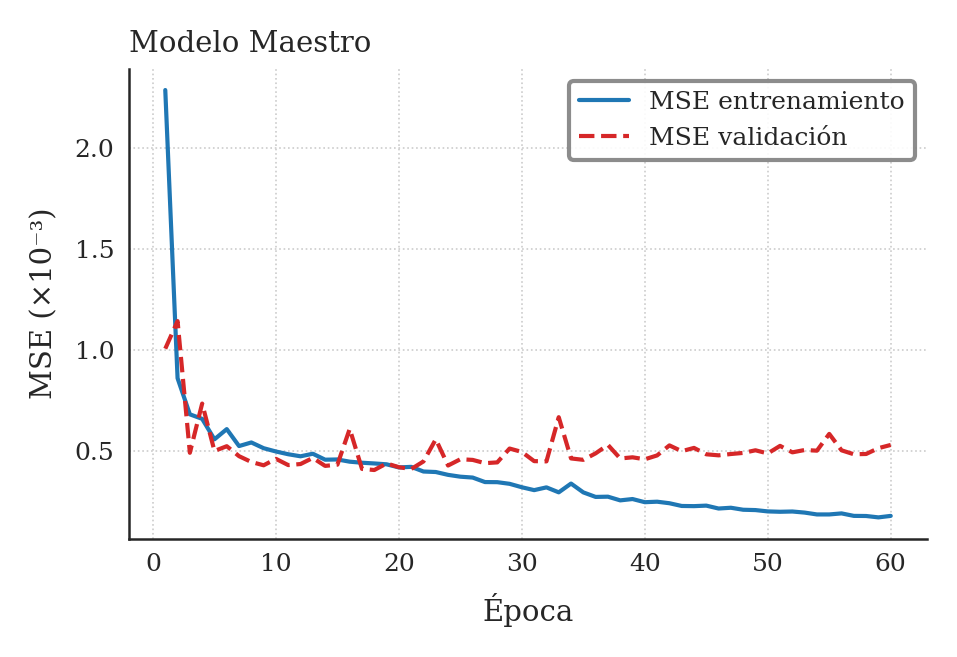

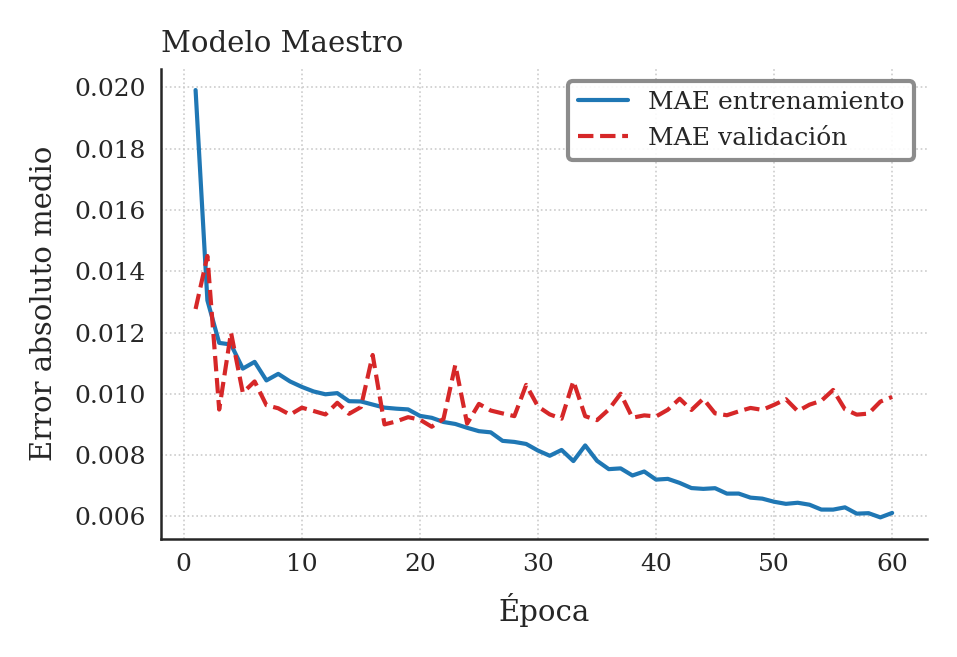

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Estilo general
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 7,
    'font.family': 'serif',
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'lines.linewidth': 1,
    'axes.linewidth': 0.6,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Cargar los valores
loss = np.load('loss_teacher2_60.npy')
mae = np.load('mae_teacher2_60.npy')
val_loss = np.load('val_loss_teacher2_60.npy')
val_mae = np.load('val_mae_teacher2_60.npy')

epochs = range(1, len(loss) + 1)
figsize = (3.2, 2.2)

# === MSE ===
plt.figure(figsize=figsize)
plt.plot(epochs, loss * 1e3, color='tab:blue', label='MSE entrenamiento')
plt.plot(epochs, val_loss * 1e3, color='tab:red', linestyle='--', label='MSE validación')

plt.xlabel('Época')
plt.ylabel('MSE (×10⁻³)')
plt.grid(True, which='both', linestyle=':', linewidth=0.4)
plt.title('Modelo Maestro', fontsize=7, loc='left', pad=4)

# Leyenda en esquina superior derecha, con borde discreto
plt.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray', fontsize=6)
plt.tight_layout()
plt.savefig('mse_teacher_caja.pdf')
plt.show()

# === MAE ===
plt.figure(figsize=figsize)
plt.plot(epochs, mae, color='tab:blue', label='MAE entrenamiento')
plt.plot(epochs, val_mae, color='tab:red', linestyle='--', label='MAE validación')

plt.xlabel('Época')
plt.ylabel('Error absoluto medio')
plt.grid(True, which='both', linestyle=':', linewidth=0.4)
plt.title('Modelo Maestro', fontsize=7, loc='left', pad=4)

plt.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray', fontsize=6)
plt.tight_layout()
plt.savefig('mae_teacher_caja.pdf')
plt.show()


#### Guardar modelo Teacher

In [ ]:
teacher.save('modelo_teacher2.h5')


In [ ]:
# Si es una sola muestra:
X_1=X_test[40]
Y_1=Y_test[40]
print(Y_1)
prediccion = teacher.predict(np.expand_dims(X_1, axis=0))
print(prediccion)

[0.546875 0.001    0.001   ]
1/1 [==============================] - 0s 96ms/step
[[0.52457047 0.00116966 0.00079716]]


## Modelo Alumno Cuantizado

In [104]:
## Estrategia de cuantización

## Definición del número de bits para kernel, bias, y activación.
# 8-bits

def build_student():

        kernelQ = "quantized_bits(bits=8, integer=1, keep_negative=True)"
        biasQ = "quantized_bits(bits=8, integer=2, keep_negative=True)"
        activationQ = 'quantized_bits(bits=8, integer=1, keep_negative=True)'
        activationQ_out = 'quantized_bits(bits=16, integer=0, keep_negative=False)'

        modelQ_QAP = Sequential(
                [   
                        #Flatten(input_shape=(512, 1)),
                        QDense(8, input_shape = (X_train.shape[1],),name='fc1',
                                kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                                kernel_initializer='lecun_uniform'),
                        QActivation(activation= activationQ ,  name='relu1'),

                        Dropout(0.1),

                        #QDense(8, name='fc2',
                        #        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        #        kernel_initializer='lecun_uniform'),
                        #QActivation(activation=activationQ, name='relu2'), 
                        #Dropout(0.1),

                        #QDense(32, name='fc3',
                        #        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        #        kernel_initializer='lecun_uniform'),
                        #QActivation(activation=activationQ, name='relu3'), 
                        #Dropout(0.1),
                                                
                        QDense(3, name='output',
                                kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                                kernel_initializer='lecun_uniform'),
                                QActivation(activation=activationQ_out, name='relu_out'), 
                        # Activation(activation='softmax', name='softmax')
                
                ],

                name="quantizedModel",
                )
        return modelQ_QAP

CREAR EL MODELO STUDENT QUANTIZADO

In [105]:
student = build_student()
student.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 8)                 4104      
                                                                 
 relu1 (QActivation)         (None, 8)                 0         
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 output (QDense)             (None, 3)                 27        
                                                                 
 relu_out (QActivation)      (None, 3)                 0         
                                                                 
Total params: 4,131
Trainable params: 4,131
Non-trainable params: 0
_________________________________________________________________


## Proceso de destilación

CREAMOS UN MODELO PERSONALIZADO PARA EL ENTRENAMMIENTO
Creamos una función de pèrdidas combinada==>  combinar dos funciones de pérdida:

🔹 loss_true: error entre la salida del Student y los valores verdaderos (y_train)

🔸 loss_teacher: error entre la salida del Student y la salida del Teacher (teacher(x_train))

Luego las mezclamos con un parámetro α (alpha):

In [92]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import Mean, MeanSquaredError

class DistilledModel(Model):
    def __init__(self, student, teacher, alpha=0.5):
        super(DistilledModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.alpha = alpha

        # Métricas de entrenamiento
        self.train_loss_tracker = Mean(name="loss")
        self.mse_var0 = MeanSquaredError(name="mse_var0")
        self.mse_var1 = MeanSquaredError(name="mse_var1")
        self.mse_var2 = MeanSquaredError(name="mse_var2")

        # Métricas de validación
        self.val_loss_tracker = Mean(name="val_loss")
        self.val_mse_var0 = MeanSquaredError(name="val_mse_var0")
        self.val_mse_var1 = MeanSquaredError(name="val_mse_var1")
        self.val_mse_var2 = MeanSquaredError(name="val_mse_var2")

    def compile(self, optimizer, loss_fn):
        super(DistilledModel, self).compile()
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        teacher_pred = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)
            loss_true = self.loss_fn(y, student_pred)
            loss_teacher = self.loss_fn(teacher_pred, student_pred)
            loss = self.alpha * loss_true + (1 - self.alpha) * loss_teacher

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.train_loss_tracker.update_state(loss)

        self.mse_var0.update_state(y[:, 0], student_pred[:, 0])
        self.mse_var1.update_state(y[:, 1], student_pred[:, 1])
        self.mse_var2.update_state(y[:, 2], student_pred[:, 2])

        return {
            "loss": self.train_loss_tracker.result(),
            "mse_var0": self.mse_var0.result(),
            "mse_var1": self.mse_var1.result(),
            "mse_var2": self.mse_var2.result()
        }

    def test_step(self, data):
        x, y = data
        teacher_pred = self.teacher(x, training=False)
        student_pred = self.student(x, training=False)

        loss_true = self.loss_fn(y, student_pred)
        loss_teacher = self.loss_fn(teacher_pred, student_pred)
        loss = self.alpha * loss_true + (1 - self.alpha) * loss_teacher

        self.val_loss_tracker.update_state(loss)

        self.val_mse_var0.update_state(y[:, 0], student_pred[:, 0])
        self.val_mse_var1.update_state(y[:, 1], student_pred[:, 1])
        self.val_mse_var2.update_state(y[:, 2], student_pred[:, 2])

        return {
            "val_loss": self.val_loss_tracker.result(),
            "val_mse_var0": self.val_mse_var0.result(),
            "val_mse_var1": self.val_mse_var1.result(),
            "val_mse_var2": self.val_mse_var2.result()
        }

    @property
    def metrics(self):
        return [
            self.train_loss_tracker,
            self.mse_var0,
            self.mse_var1,
            self.mse_var2,
            self.val_loss_tracker,
            self.val_mse_var0,
            self.val_mse_var1,
            self.val_mse_var2,
        ]


In [93]:
teacher = tf.keras.models.load_model("modelo_teacher2.h5")
teacher.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 512, 128)          768       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 256, 128)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 256, 64)           41024     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 128, 64)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 128, 164)          52644     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 64, 164)         

ENTRENAMIENTO DEL MODELO DESTILADO

In [94]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Métrica a monitorear (puede ser 'val_loss', 'val_accuracy', etc.)
    patience=4,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaura los mejores pesos al final del entrenamiento
)

In [95]:
distilled = DistilledModel(student=student, teacher=teacher, alpha=0.55)
distilled.compile(optimizer=Adam(learning_rate=0.001), loss_fn=tf.keras.losses.MeanSquaredError())

history = distilled.fit(
    X_train,
    Y_train,
    epochs=60,
    batch_size=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop]  # Se pasa el callback de early stopping
)


Epoch 1/60


2025-04-27 14:46:35.927065: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91750400 exceeds 10% of free system memory.


896/896 [==============================] - 12s 13ms/step - loss: 0.0115 - mse_var0: 0.0335 - mse_var1: 2.1565e-04 - mse_var2: 9.6177e-04 - val_val_loss: 0.0047 - val_val_mse_var0: 0.0142 - val_val_mse_var1: 6.8775e-06 - val_val_mse_var2: 3.5690e-05
Epoch 2/60
896/896 [==============================] - 11s 12ms/step - loss: 0.0067 - mse_var0: 0.0202 - mse_var1: 4.9290e-05 - mse_var2: 2.5136e-05 - val_val_loss: 0.0048 - val_val_mse_var0: 0.0143 - val_val_mse_var1: 1.0000e-06 - val_val_mse_var2: 1.0304e-06
Epoch 3/60
896/896 [==============================] - 11s 12ms/step - loss: 0.0061 - mse_var0: 0.0183 - mse_var1: 1.6203e-05 - mse_var2: 1.0529e-05 - val_val_loss: 0.0050 - val_val_mse_var0: 0.0153 - val_val_mse_var1: 1.0000e-06 - val_val_mse_var2: 1.4683e-06
Epoch 4/60
896/896 [==============================] - 11s 12ms/step - loss: 0.0057 - mse_var0: 0.0172 - mse_var1: 1.3003e-05 - mse_var2: 1.2066e-05 - val_val_loss: 0.0052 - val_val_mse_var0: 0.0149 - val_val_mse_var1: 9.2398e-04 - 

MÉTRICAS

In [22]:
print(history.history.keys())


dict_keys(['loss', 'mse_var0', 'mse_var1', 'mse_var2', 'val_val_loss', 'val_val_mse_var0', 'val_val_mse_var1', 'val_val_mse_var2'])


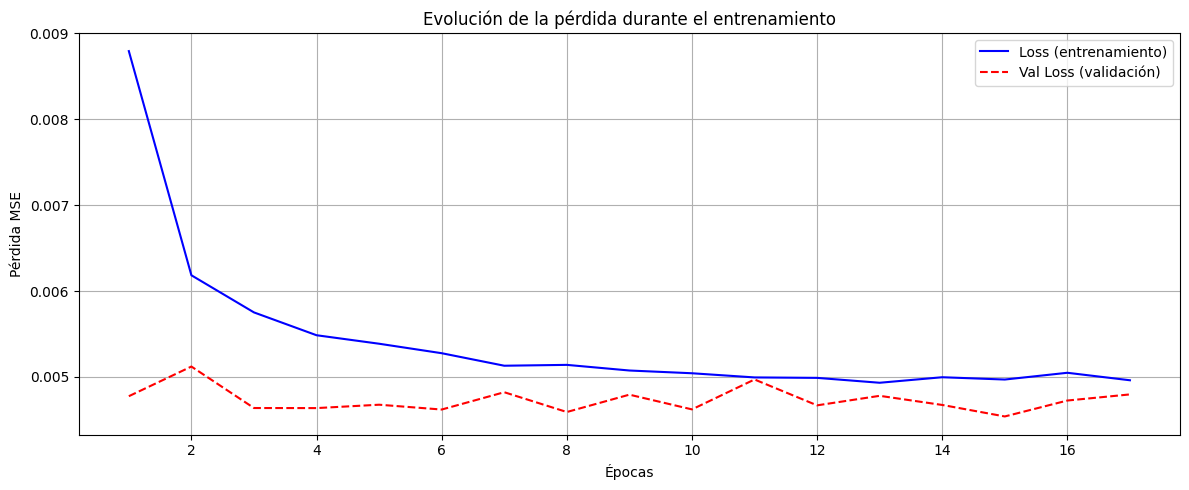

In [23]:
import matplotlib.pyplot as plt

# Acceder a las pérdidas del entrenamiento
loss = history.history['loss']
val_loss = history.history['val_val_loss']
epochs = range(1, len(loss) + 1)

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(epochs, loss, 'b-', label='Loss (entrenamiento)')
plt.plot(epochs, val_loss, 'r--', label='Val Loss (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida MSE')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


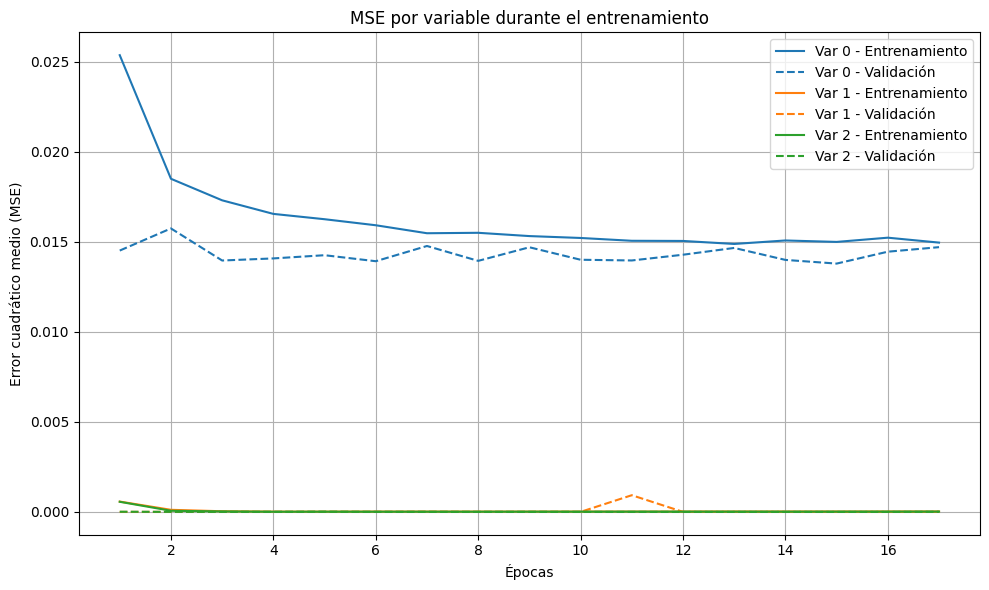

In [24]:
import matplotlib.pyplot as plt

# Obtener métricas del historial
epochs = range(1, len(history.history['loss']) + 1)

# Colores para cada variable
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Títulos de las variables
variables = ['Var 0', 'Var 1', 'Var 2']

# Métricas
train_mse = ['mse_var0', 'mse_var1', 'mse_var2']
val_mse = ['val_val_mse_var0', 'val_val_mse_var1', 'val_val_mse_var2']  # ← acá está el fix

plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(epochs, history.history[train_mse[i]], linestyle='-', color=colors[i], label=f'{variables[i]} - Entrenamiento')
    plt.plot(epochs, history.history[val_mse[i]], linestyle='--', color=colors[i], label=f'{variables[i]} - Validación')

plt.title('MSE por variable durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Para guardar valores y luego levantarlo y graficar los vectores desde archivo

In [25]:
# Guardamos cada métrica por separado
np.save('./alumno_17/loss_alumno_17.npy', np.array(history.history['loss']))
np.save('./alumno_17/val_loss_alumno_17.npy', np.array(history.history['val_val_loss']))
np.save('./alumno_17/loss_alumno_mse_var0_17.npy', np.array(history.history['mse_var0']))
np.save('./alumno_17/loss_alumno_mse_var1_17.npy', np.array(history.history['mse_var1']))
np.save('./alumno_17/loss_alumno_mse_var2_17.npy', np.array(history.history['mse_var2']))
np.save('./alumno_17/val_loss_alumno_mse_var0_17.npy', np.array(history.history['val_val_mse_var0']))
np.save('./alumno_17/val_loss_alumno_mse_var1_17.npy', np.array(history.history['val_val_mse_var1']))
np.save('./alumno_17/val_loss_alumno_mse_var2_17.npy', np.array(history.history['val_val_mse_var2']))

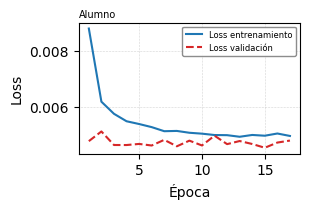

In [27]:
# Cargar los valores para el gráfico de pérdida
loss = np.load('./alumno_17/loss_alumno_17.npy')
val_loss = np.load('./alumno_17/val_loss_alumno_17.npy')

epochs = range(1, len(loss) + 1)
figsize = (3.2, 2.2)

# === Gráfico Loss y Val Loss ===
plt.figure(figsize=figsize)
plt.plot(epochs, loss, color='tab:blue', label='Loss entrenamiento')
plt.plot(epochs, val_loss, color='tab:red', linestyle='--', label='Loss validación')

plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle=':', linewidth=0.4)
plt.title('Alumno', fontsize=7, loc='left', pad=4)

# Leyenda en esquina superior derecha, con borde discreto
plt.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray', fontsize=6)
plt.tight_layout()
plt.savefig('./alumno_17/figuras/loss_alumno_17.pdf')
plt.show()


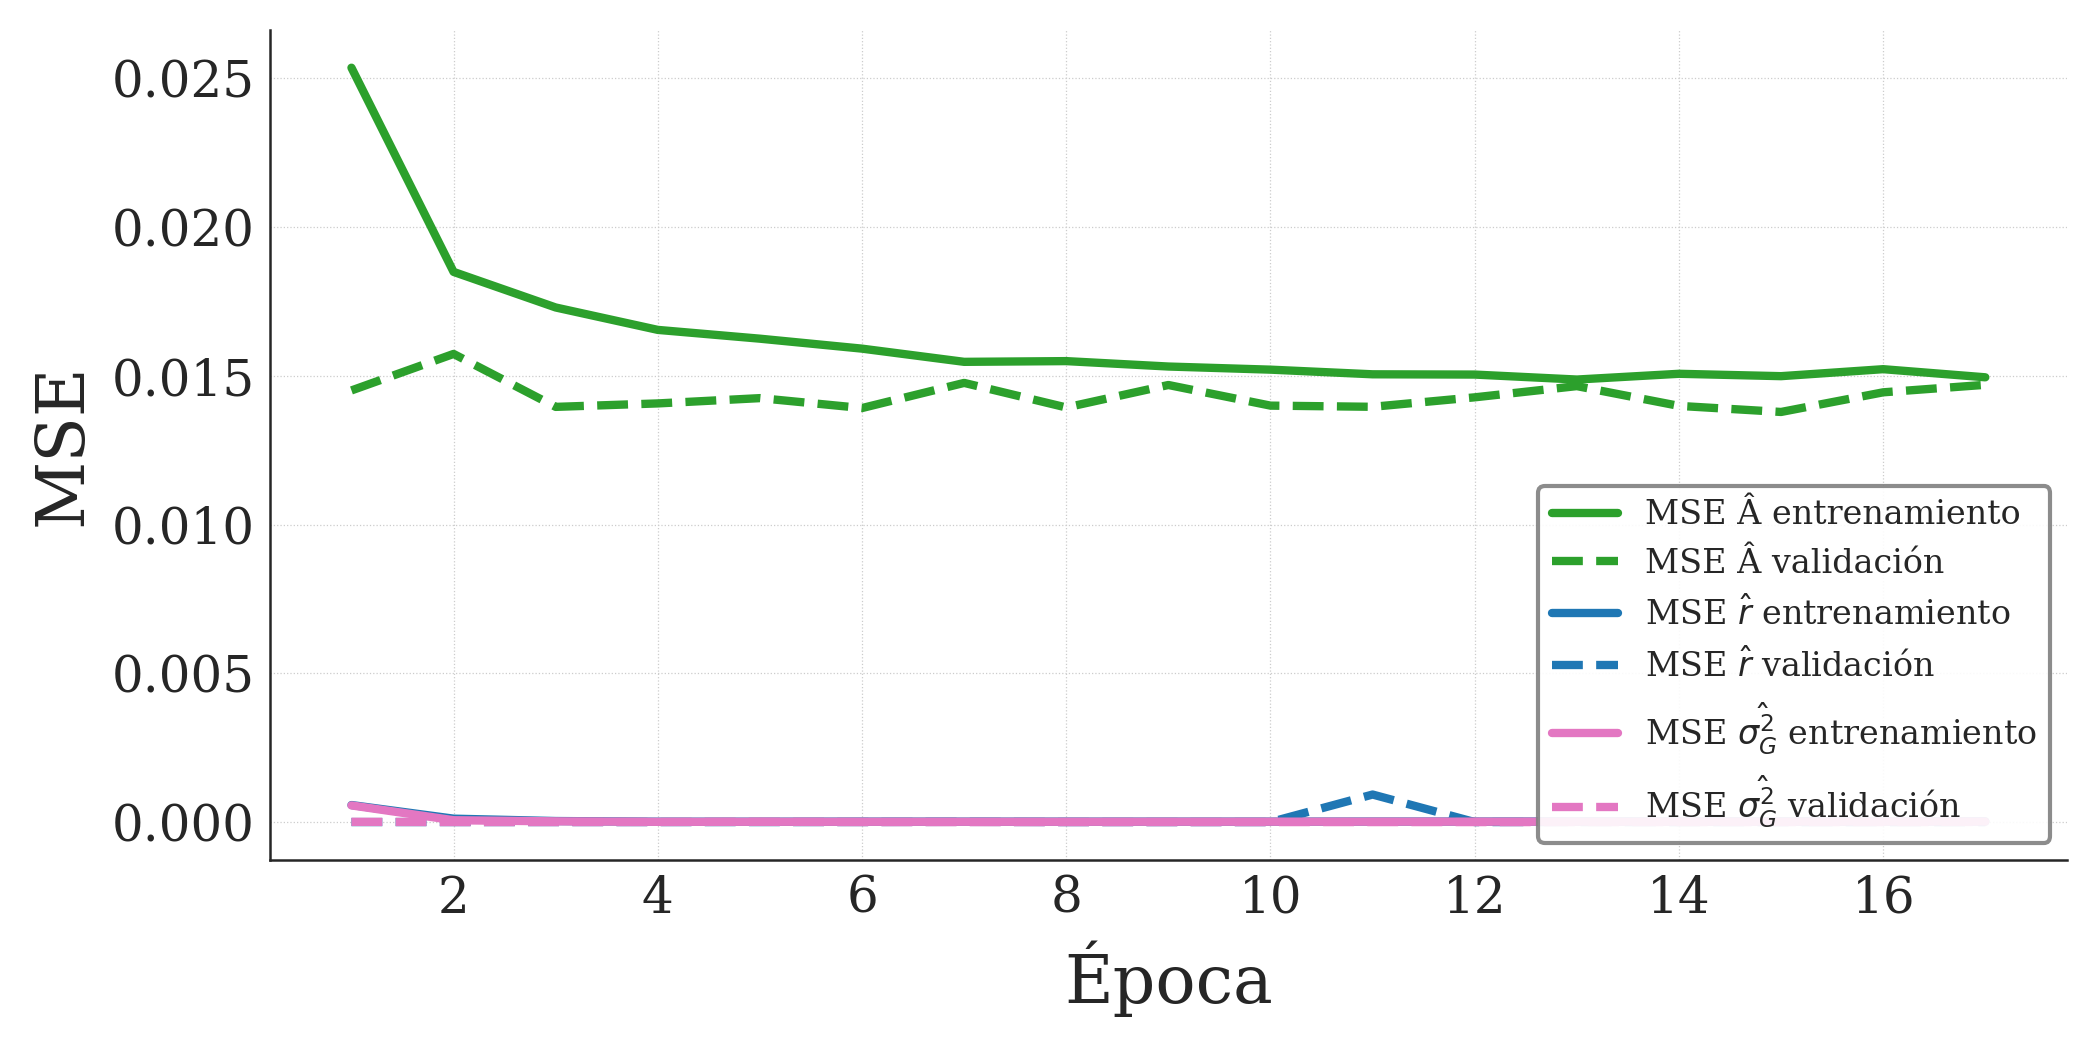

In [14]:
# Estilo general
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 7,
    'font.family': 'serif',
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'lines.linewidth': 1,
    'axes.linewidth': 0.6,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Cargar los valores para todas las métricas
loss = np.load('./alumno_17/loss_alumno_17.npy')
val_loss = np.load('./alumno_17/val_loss_alumno_17.npy')
mse_var0 = np.load('./alumno_17/loss_alumno_mse_var0_17.npy')
val_mse_var0 = np.load('./alumno_17/val_loss_alumno_mse_var0_17.npy')
mse_var1 = np.load('./alumno_17/loss_alumno_mse_var1_17.npy')
val_mse_var1 = np.load('./alumno_17/val_loss_alumno_mse_var1_17.npy')
mse_var2 = np.load('./alumno_17/loss_alumno_mse_var2_17.npy')
val_mse_var2 = np.load('./alumno_17/val_loss_alumno_mse_var2_17.npy')

epochs = range(1, len(loss) + 1)
figsize = (7, 3.5)

# === Gráfico para todas las métricas ===
plt.figure(figsize=figsize)
plt.plot(epochs, mse_var0, color='tab:green', label='MSE Â entrenamiento', linewidth = 2)
plt.plot(epochs, val_mse_var0, color='tab:green', linestyle='--', label='MSE Â validación', linewidth = 2)
plt.plot(epochs, mse_var1, color='tab:blue', label=r'MSE $\hat{r}$ entrenamiento', linewidth = 2)
plt.plot(epochs, val_mse_var1, color='tab:blue', linestyle='--', label='MSE $\hat{r}$ validación', linewidth = 2)
plt.plot(epochs, mse_var2, color='tab:pink', label='MSE $\hat{\sigma_{G}^2}$ entrenamiento', linewidth = 2)
plt.plot(epochs, val_mse_var2, color='tab:pink', linestyle='--', label='MSE $\hat{\sigma_{G}^2}$ validación', linewidth = 2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.xlabel('Época', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.grid(True, which='both', linestyle=':', linewidth=0.3)
#plt.title('Modelo Alumno', fontsize=20, loc='left', pad=4)

# Leyenda en esquina superior derecha, con borde discreto
plt.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray', fontsize=8)
plt.tight_layout()
plt.savefig('./alumno_17/figuras/metricas_alumno_17.pdf')
plt.savefig('./alumno_17/figuras/metricas_alumno_17.png')
plt.show()


In [29]:
distilled.student.save('./alumno_17/modelo_alumno/student_17.h5')  # El posta es el de 60 epocas, pero hls no tiene QAdaptiveActivacion. Estoy haciendo pruebas con este de dos epocas de entrenamiento

### inferencia

In [32]:
# Si es una sola muestra:
X_1=X_test[2000]
Y_1=Y_test[2000]
print(Y_1)
prediccion = distilled.student.predict(np.expand_dims(X_1, axis=0))
print(prediccion)



[0.3359375 0.001     0.001    ]
1/1 [==============================] - 0s 13ms/step
[[0.3966217  0.         0.00059509]]


### Inferencia 2

In [33]:
from qkeras import QActivation
from qkeras import QDense
from qkeras import quantizers
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings


print_qstats(distilled.student)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    fc1                           : 4096  (smult_8_8)
    output                        : 24    (smult_8_8)

Number of operation types in model:
    smult_8_8                     : 4120

Weight profiling:
    fc1_weights                    : 4096  (8-bit unit)
    fc1_bias                       : 8     (8-bit unit)
    output_weights                 : 24    (8-bit unit)
    output_bias                    : 3     (8-bit unit)

Weight sparsity:
... quantizing model
    fc1                            : 0.0134
    output                         : 0.0741
    ----------------------------------------
    Total Sparsity                 : 0.0138


In [34]:
from qkeras import quantizers
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from qkeras import QConv1D, QDense, QActivation, QAdaptiveActivation

custom_objects = {
    #"QConv1D": QConv1D,
    "QDense": QDense,
    "QActivation": QActivation,
    #"QBatchNormalization": QBatchNormalization,
    # agregá otras si hiciste quantización de activaciones o usaste layers como QBatchNormalization
}

student_model = tf.keras.models.load_model("./alumno_17/modelo_alumno/student_17.h5", custom_objects=custom_objects)

print_qstats(student_model)


Number of operations in model:
    fc1                           : 4096  (smult_8_8)
    output                        : 24    (smult_8_8)

Number of operation types in model:
    smult_8_8                     : 4120

Weight profiling:
    fc1_weights                    : 4096  (8-bit unit)
    fc1_bias                       : 8     (8-bit unit)
    output_weights                 : 24    (8-bit unit)
    output_bias                    : 3     (8-bit unit)

Weight sparsity:
... quantizing model
    fc1                            : 0.0134
    output                         : 0.0741
    ----------------------------------------
    Total Sparsity                 : 0.0138


# PRUNING al modelo STUDENT entrenado y quantizado

In [35]:
from qkeras import QConv1D, QDense, QActivation

custom_objects = {
    #"QConv1D": QConv1D,
    "QDense": QDense,
    "QActivation": QActivation,
    #"QBatchNormalization": QBatchNormalization,
    # agregá otras si hiciste quantización de activaciones o usaste layers como QBatchNormalization
}

student_model = tf.keras.models.load_model("./alumno_17/modelo_alumno/student_17.h5", custom_objects=custom_objects)


In [36]:
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

def apply_pruning_to_supported_layers(model, pruning_params):
    from tensorflow.keras.models import Sequential
    new_model = Sequential()
    for layer in model.layers:
        if isinstance(layer, (QConv1D, QDense)):
            new_model.add(prune_low_magnitude(layer, **pruning_params))
        else:
            new_model.add(layer)
    return new_model


In [37]:
# Parámetros de pruning
final_sparsity = 0.2
epochs = 10
batch = 32

# Usás todos los datos de entrenamiento (sin dividir)
steps_per_epoch = len(X_train) // batch
end_step = steps_per_epoch * epochs

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=final_sparsity,
        begin_step=0,
        end_step=end_step
    )
}

In [38]:
#student_model = tf.keras.models.load_model("student_60.h5", custom_objects=custom_objects)
model_studentQAP = apply_pruning_to_supported_layers(student_model, pruning_params)

In [39]:
# Forzar construcción de las capas de pruning
model_studentQAP.build(input_shape=(None, 512, 1))
# O mejor aún, hacé una pasada con datos reales (sin entrenamiento)
model_studentQAP.predict(X_train[:1])


1/1 [==============================] - 0s 279ms/step


array([[3.9381409e-01, 0.0000000e+00, 1.5258789e-04]], dtype=float32)

In [40]:
# Compilar modelo
model_studentQAP.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)



In [41]:
# Entrenar con datos de validación explícitos
H = model_studentQAP.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    verbose=1
)

Epoch 1/10


2025-04-27 13:43:43.227534: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91750400 exceeds 10% of free system memory.


1400/1400 [==============================] - 4s 1ms/step - loss: 0.0050 - mae: 0.0321 - val_loss: 0.0047 - val_mae: 0.0308
Epoch 2/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0051 - mae: 0.0324 - val_loss: 0.0048 - val_mae: 0.0304
Epoch 3/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0050 - mae: 0.0321 - val_loss: 0.0064 - val_mae: 0.0369
Epoch 4/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0050 - mae: 0.0322 - val_loss: 0.0046 - val_mae: 0.0301
Epoch 5/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0051 - mae: 0.0325 - val_loss: 0.0046 - val_mae: 0.0302
Epoch 6/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0051 - mae: 0.0324 - val_loss: 0.0047 - val_mae: 0.0312
Epoch 7/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0051 - mae: 0.0325 - val_loss: 0.0047 - val_mae: 0.0307
Epoch 8/10
1400/1400 [==============================] - 1s 1ms/step - los

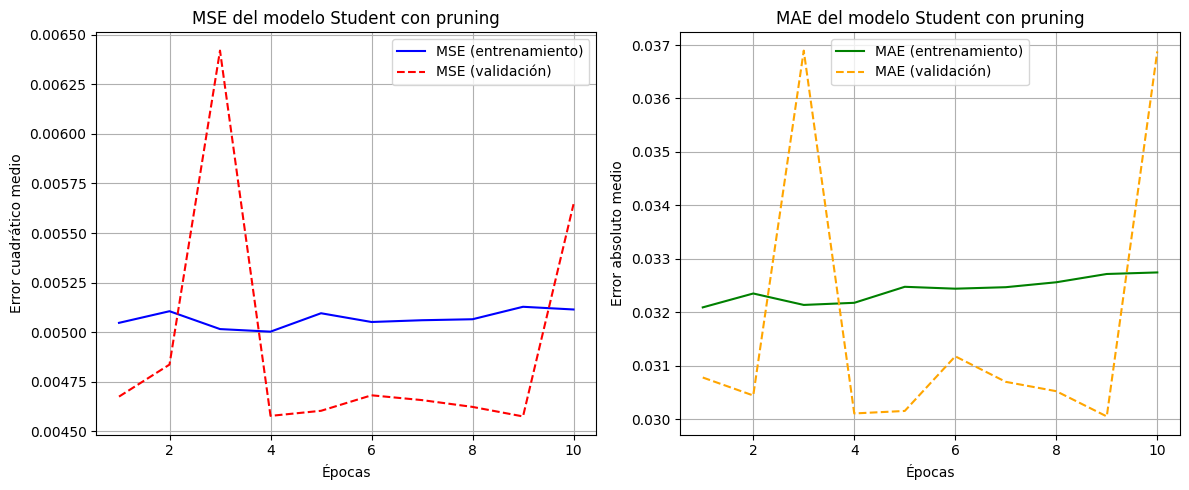

In [42]:
# 🔹 Graficar el MSE (loss) y el MAE
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, H.history['loss'], 'b-', label='MSE (entrenamiento)')
plt.plot(epochs_range, H.history['val_loss'], 'r--', label='MSE (validación)')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.title('MSE del modelo Student con pruning')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, H.history['mae'], 'g-', label='MAE (entrenamiento)')
plt.plot(epochs_range, H.history['val_mae'], 'orange', linestyle='--', label='MAE (validación)')
plt.xlabel('Épocas')
plt.ylabel('Error absoluto medio')
plt.title('MAE del modelo Student con pruning')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Inferencia despues del Pruning

In [45]:
X_1=np.load("x_test.npy")
Y_1=np.load("y_test.npy")

X_1=X_test[2000]
Y_1=Y_test[2000]

print(Y_1)
prediccion = model_studentQAP.predict(np.expand_dims(X_1, axis=0))
print(prediccion)

[0.3359375 0.001     0.001    ]
1/1 [==============================] - 0s 13ms/step
[[4.6438599e-01 0.0000000e+00 1.6784668e-04]]


### Guardar modelo Quantizado, entrenado y pruneado

In [46]:
model_studentQAP.save('./alumno_17/modelo_pruneado_post_trainning/student_pruneado_17.h5')

## OBTENER ALGUNAS MÈTRICAS

In [47]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [48]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model_studentQAP)

print_model_weights_sparsity(model_studentQAP)
print('-------------------------------------------')
stripped_pruned_model.summary()



fc1/kernel:0: 20.00% sparsity  (819/4096)
fc1/bias:0: 0.00% sparsity  (0/8)
output/kernel:0: 20.83% sparsity  (5/24)
output/bias:0: 0.00% sparsity  (0/3)
-------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 8)                 4104      
                                                                 
 relu1 (QActivation)         (None, 8)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 output (QDense)             (None, 3)                 27        
                                                                 
 relu_out (QActivation)      (None, 3)                 0         
                                                        

In [49]:
model_export = tfmot.sparsity.keras.strip_pruning(model_studentQAP)
model_export.save('./alumno_17/modelo_pruneado_post_trainning/student_stripped_17.h5')


# ETAPA DE PREPARACIÓN PARA IMPLEMENTAR ...

In [50]:
import hls4ml
import matplotlib.pyplot as plt
from qkeras.utils import load_qmodel
import os

/home/lucas/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Como paso inicial se debe especificar el directorio de instalación de Vivado HLS o Vitis HLS. 

In [51]:
# Path donde se encuentra instalado Vitis HLS!! : os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# Para MÁQUINA VIRTUAL!
os.environ['PATH'] = '/home/lucas/Xilinx/Vitis_HLS/2022.2/bin:' + os.environ['PATH']
os.environ['PATH']


'/home/lucas/Xilinx/Vitis_HLS/2022.2/bin:/home/lucas/anaconda3/envs/neuralEnv/bin:/home/celeste/Xilinx/Vitis_HLS/2022.2/bin:/usr/games:/home/celeste/Xilinx/Vitis_HLS/2022.2/bin:/home/lucas/.nvm/versions/node/v18.17.1/bin:/home/lucas/anaconda3/condabin:/home/celeste/Xilinx/Vitis_HLS/2022.2/bin:/usr/games:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin'

### Carga del modelo (.h5)

In [52]:
from qkeras import QConv1D, QDense, QActivation

custom_objects = {
    # "QConv1D": QConv1D,
    "QDense": QDense,
    "QActivation": QActivation,
    # "QBatchNormalization": QBatchNormalization,
    # agregá otras si hiciste quantización de activaciones o usaste layers como QBatchNormalization
}


In [53]:
# model = load_qmodel('student_stripped_60.h5', custom_objects=custom_objects)  # ya no necesita el wrapper de pruning
model = load_qmodel('./alumno_17/modelo_pruneado_post_trainning/student_stripped_17.h5', custom_objects=custom_objects)  # ya no necesita el wrapper de pruning

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 8)                 4104      
                                                                 
 relu1 (QActivation)         (None, 8)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 output (QDense)             (None, 3)                 27        
                                                                 
 relu_out (QActivation)      (None, 3)                 0         
                                                                 
Total params: 4,131
Trainable params: 4,131
Non-trainable params: 0
_________________________________________________________________


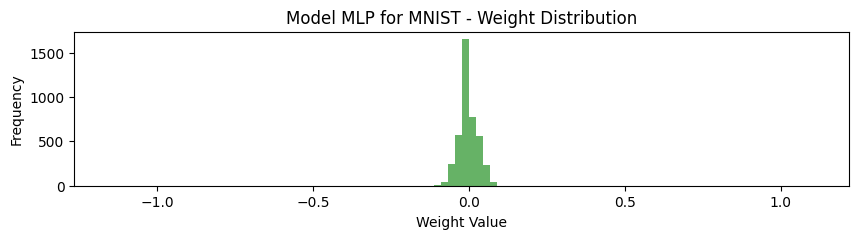

In [54]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=100, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Model MLP for MNIST - Weight Distribution")
plt.show()


## hls4ml 

 Si usás granularity='name', estás generando una configuración donde cada capa puede tener su propio ajuste específico de precisión, lo cual te da mucho control. Ahora si podes granularity=model te pone todas las capas del modelo con la misma precision.

In [63]:
from qkeras.utils import _add_supported_quantized_objects

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='model')
import plotting

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: prune_low_magnitude_fc1_input, layer type: InputLayer, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: fc1, layer type: QDense, input shapes: [[None, 512]], output shape: [None, 8]
Layer name: relu1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: output, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 3]
Layer name: relu_out, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------


In [74]:
# Lista de capas con sus configuraciones
layer_config = {
    #'flatten_57': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 500},
    'fc1': {'Precision': 'ap_fixed<8,1>', 'ReuseFactor': 512, 'Strategy': 'Resource'},
    'output': {'Precision': 'ap_fixed<8,1>', 'ReuseFactor': 1},
    'relu1': {'Precision': 'ap_fixed<8,1>', 'ReuseFactor': 1},
    'relu_out': {'Precision': 'ap_fixed<16,0>'},
}

# Inicializamos LayerName si no existe
hls_config.setdefault('LayerName', {})

# Asignamos Precision y ReuseFactor a cada capa
for layer, config in layer_config.items():
    hls_config['LayerName'].setdefault(layer, {})
    for param, value in config.items():
        hls_config['LayerName'][layer][param] = value


hls_config['Model']['ReuseFactor'] = 1000
hls_config['Model']['Strategy'] = 'Stable'
hls_config['Model']['ClockPeriod'] = 12

In [75]:
print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

model.summary()

-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1000
  Strategy:          Stable
  BramFactor:        1000000000
  TraceOutput:       False
  ClockPeriod:       12
LayerName
  fc1
    Precision:       ap_fixed<8,1>
    ReuseFactor:     512
    Strategy:        Resource
  output
    Precision:       ap_fixed<8,1>
    ReuseFactor:     1
  relu1
    Precision:       ap_fixed<8,1>
    ReuseFactor:     1
  relu_out
    Precision:       ap_fixed<16,0>
-----------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 8)                 4104      
                                                                 
 relu1 (QActivation)         (None, 8)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 8)            

### hls4ml con Vitis HLS como backend

In [10]:
import os
print(os.environ.get('LD_PRELOAD'))

/usr/lib/x86_64-linux-gnu/libstdc++.so.6


In [294]:
import os
os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libstdc++.so.6'

In [76]:
cfg = hls4ml.converters.create_config(backend='Vitis')
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = './alumno_17/hlsPrj_alumno17_synth_v1/' # Cambiar para cada prueba que haya que conservar
cfg['Part'] = 'xc7z020clg484-1'
cfg['ProjectName'] = 'inference'
cfg['ClockPeriod'] = 12
# cfg['ClockUncertainty'] = 12.5 # HAY QUE PROBARLO!!! 
cfg['CXXFLAGS'] = '-std=c++14'

# cfg['IOType'] = 'io_stream'  # o 'io_parallel'


hls_model = hls4ml.converters.keras_to_hls(cfg)
#hls_model.build()
hls_model.compile()


Interpreting Sequential
Topology:
Layer name: prune_low_magnitude_fc1_input, layer type: InputLayer, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: fc1, layer type: QDense, input shapes: [[None, 512]], output shape: [None, 8]
Layer name: relu1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: output, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 3]
Layer name: relu_out, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Writing HLS project


Done


In [77]:
#Ver cuanta memoria está usando el proceso actual: 
import os, psutil

proc = psutil.Process(os.getpid())
print(f"Memoria usada por este proceso: {proc.memory_info().rss / 1e9:.2f} GB")

hls_model.build(csim=False, export=False)

Memoria usada por este proceso: 2.21 GB

****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /home/lucas/Xilinx/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/lucas/Xilinx/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'lucas' on host 'lucas-laptop' (Linux_x86_64 version 6.5.0-44-generic) on Sun Apr 27 14:31:19 -03 2025
INFO: [HLS 200-10] On os Ubuntu 23.10
INFO: [HLS 200-10] In directory '/home/lucas/Escritorio/IA_Middleton/alumno_17/hlsPrj_alumno17_synth_v1'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project inference_prj 
INFO: [HLS 200-10] Opening project '/home/lucas/Escritorio/IA_Middleton/alumno_17/hlsPrj_alumno17_synth_v1/inference_prj'.
INFO: [HLS 200-1510] Running: set_top inference 
INFO: [

{'CSynthesisReport': {'TargetClockPeriod': '12.00',
  'EstimatedClockPeriod': '9.754',
  'BestLatency': '519',
  'WorstLatency': '520',
  'IntervalMin': '512',
  'IntervalMax': '512',
  'BRAM_18K': '8',
  'DSP': '8',
  'FF': '19954',
  'LUT': '6191',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

In [214]:
Y= np.load("/home/celeste/Escritorio/INVESTIGACION/IA_Middleton/y_train2.npy")
X= np.load("/home/celeste/Escritorio/INVESTIGACION/IA_Middleton/x_train2.npy")
# Normalizar X fila a fila entre 0 y 1
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)  # Se suma un pequeño valor para evitar división por cero

In [228]:
# Si es una sola muestra:
i = np.random.randint(0,X.shape[0])
print(f"muestra: {i:d}")
X_1=X_norm[i]
Y_1=Y[i]
print(Y_1)
prediccion = model.predict(np.expand_dims(X_1, axis=0))
print(prediccion)
print()
print(Y_1*1024)
print(prediccion*1024)

muestra: 24182
[0.3828125 0.001     0.001    ]
1/1 [==============================] - 0s 16ms/step
[[0.40625 0.      0.     ]]

[392.      1.024   1.024]
[[416.   0.   0.]]


In [226]:
print(X_norm[i,:3])
print(X_norm[i,:3]*1024)

[0.00453576 0.00256072 0.00593075]
[4.64461702 2.62217221 6.07309123]


In [147]:
XX_1 = (X_1*1024).astype(np.int32)/1024

print(Y_1)
prediccion = model.predict(np.expand_dims(XX_1, axis=0))
print(prediccion)
print()
print(Y_1*1024)
print(prediccion*1024)

[0.2109375 0.001     0.001    ]
1/1 [==============================] - 0s 15ms/step
[[ 1.8786621e-01  1.2207031e-04 -7.0343018e-03]]

[216.      1.024   1.024]
[[ 1.923750e+02  1.250000e-01 -7.203125e+00]]
